In [109]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from django.db.models import F, Count, Max
from utils.tm_mgmt import *

run_id = 483

In [111]:
dts = DynamicTopic.objects.filter(run_id=run_id)

dts

<QuerySet [<DynamicTopic: {gas, coal, greenhous}>, <DynamicTopic: {cal, holocen, dure}>, <DynamicTopic: {manag, risk, wast}>, <DynamicTopic: {per, thousand, part}>, <DynamicTopic: {groundwat, flow, recharg}>, <DynamicTopic: {glacier, mass, balanc}>, <DynamicTopic: {year, period, annual}>, <DynamicTopic: {increas, decreas, effect}>, <DynamicTopic: {cost, optim, econom}>, <DynamicTopic: {warm, global, centuri}>, <DynamicTopic: {delta, isotop, valu}>, <DynamicTopic: {crop, yield, wheat}>, <DynamicTopic: {energi, renew, consumpt}>, <DynamicTopic: {ocean, southern, marin}>, <DynamicTopic: {region, area, climat}>, <DynamicTopic: {site, differ, peat}>, <DynamicTopic: {genet, divers, gene}>, <DynamicTopic: {atlant, north, circul}>, <DynamicTopic: {phenolog, flower, date}>, <DynamicTopic: {urban, citi, area}>, '...(remaining elements truncated)...']>

In [110]:
stat = RunStats.objects.get(run_id=run_id)
periods = stat.periods.all().order_by('n')
periods.values()

<QuerySet [{'id': 28, 'ys': [1985, 1986, 1987, 1988, 1989, 1990], 'n': 1, 'title': 'AR1'}, {'id': 29, 'ys': [1991, 1992, 1993, 1994], 'n': 2, 'title': 'AR2'}, {'id': 30, 'ys': [1995, 1996, 1997, 1998, 1999, 2000], 'n': 3, 'title': 'AR3'}, {'id': 31, 'ys': [2001, 2002, 2003, 2004, 2005, 2006, 2007], 'n': 4, 'title': 'AR4'}, {'id': 32, 'ys': [2008, 2009, 2010, 2011, 2012, 2013], 'n': 5, 'title': 'AR5'}, {'id': 33, 'ys': [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033, 2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2

In [191]:
alldts = DynamicTopic.objects.filter(run_id=run_id)

wg_dict = []

for p in periods:
    print(p.title)
    wgs = [
        {"WG":1, "score": 0},
        {"WG":2, "score": 0},
        {"WG":3, "score": 0}
    ]
    for topic in alldts.iterator():
        for w in wgs:
            wg = {
                "WG": w["WG"],
                "score": 0
            }
            wg['topic_id'] = topic.id
            wg['topic_title'] = topic.title
            wg['tscore'] = topic.score
            wg['period'] = p.title
            ts = dts.filter(
                topicdtopic__dynamictopic=topic,
                topicdtopic__topic__doctopic__doc__PY__in=p.ys,
                topicdtopic__topic__doctopic__doc__ipccref__wg__wg=wg["WG"],
                topicdtopic__topic__doctopic__doc__ipccref__isnull=False
            )
            if ts.count() == 0:
                wg['score'] = 0
            else:
                wg['score'] = ts.annotate(
                    topic_combination = F('topicdtopic__score') * F('topicdtopic__topic__doctopic__score')
                ).aggregate(
                    s = Sum('topic_combination')
                )['s']
            wg_dict.append(wg)
    
df = pd.DataFrame.from_dict(wg_dict)

df.head()

AR1
AR2
AR3
AR4
AR5
AR6


,WG,period,score,topic_id,topic_title
0,1,AR1,0.004763,9145,"{per, thousand, part}"
1,2,AR1,0.004042,9145,"{per, thousand, part}"
2,3,AR1,0.000351,9145,"{per, thousand, part}"
3,1,AR1,0.000023,9198,"{soc, stock, soil}"
4,2,AR1,0.000002,9198,"{soc, stock, soil}"


In [10]:

def f(x):
    t = DynamicTopic.objects.get(pk=x['topic_id'])
    return t.score
df['tscore'] = df.apply(f,axis=1)

df.head()

,Unnamed: 0,WG,period,score,topic_id,topic_title,tpsum,share,tscore
0,0,1,AR1,0.004763,9145,"{per, thousand, part}",0.009155,0.520211,194.167640
1,1,2,AR1,0.004042,9145,"{per, thousand, part}",0.009155,0.441500,194.167640
2,2,3,AR1,0.000351,9145,"{per, thousand, part}",0.009155,0.038289,194.167640
3,3,1,AR1,0.000023,9198,"{soc, stock, soil}",0.000025,0.939211,243.553848
4,4,2,AR1,0.000002,9198,"{soc, stock, soil}",0.000025,0.060789,243.553848


In [37]:
df.to_csv('dts.csv')

In [61]:
df = pd.read_csv('dts.csv', index_col=0)
df = df[df['period']!="AR6"]
df.head()

,WG,period,score,topic_id,topic_title,tpsum,share,tscore
0,1,AR1,0.004763,9145,"{per, thousand, part}",0.009155,0.520211,194.167640
1,2,AR1,0.004042,9145,"{per, thousand, part}",0.009155,0.441500,194.167640
2,3,AR1,0.000351,9145,"{per, thousand, part}",0.009155,0.038289,194.167640
3,1,AR1,0.000023,9198,"{soc, stock, soil}",0.000025,0.939211,243.553848
4,2,AR1,0.000002,9198,"{soc, stock, soil}",0.000025,0.060789,243.553848


In [62]:
df['tpsum'] = df['score'].groupby([df['period'],df['topic_title']]).transform('sum')
df['share'] = df['score'] / df['tpsum']
df.sort_values(['topic_title','period']).head(15)

,WG,period,score,topic_id,topic_title,tpsum,share,tscore
141,1,AR1,0.000057,9213,"{adapt, capac, local}",0.000061,0.939211,419.312076
142,2,AR1,0.000004,9213,"{adapt, capac, local}",0.000061,0.060789,419.312076
143,3,AR1,0.000000,9213,"{adapt, capac, local}",0.000061,0.000000,419.312076
441,1,AR2,0.090213,9213,"{adapt, capac, local}",0.258641,0.348795,419.312076
442,2,AR2,0.137633,9213,"{adapt, capac, local}",0.258641,0.532139,419.312076
443,3,AR2,0.030795,9213,"{adapt, capac, local}",0.258641,0.119065,419.312076
741,1,AR3,0.833699,9213,"{adapt, capac, local}",2.808169,0.296884,419.312076
742,2,AR3,1.670778,9213,"{adapt, capac, local}",2.808169,0.594971,419.312076
743,3,AR3,0.303691,9213,"{adapt, capac, local}",2.808169,0.108146,419.312076
1041,1,AR4,1.693531,9213,"{adapt, capac, local}",8.341584,0.203023,419.312076


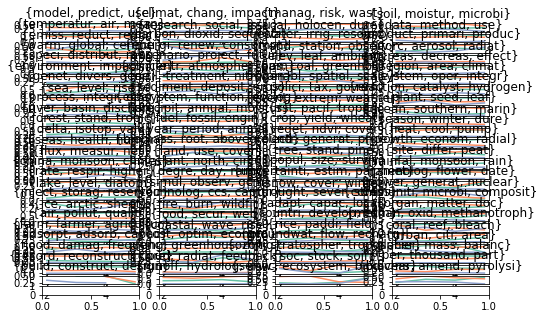

In [63]:
df = df.sort_values('tscore',ascending=False)

topics = df.topic_title.unique()

cs = 4

fig, axs = plt.subplots(len(topics)//cs+1,cs)

plt.rcParams["figure.figsize"] = [12,4*len(topics)//cs+1]

#fig, axs = plt.subplots(25,4)

for i,t in enumerate(topics):
    
    r = i // cs
    c = i % cs

    ax = axs[r][c]
    pdf = df[(df['topic_title']==t) & (df['period'] != "AR1") & (df['period'] != "AR6")].set_index('period')

    colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

    for name, group in pdf.groupby('WG'):
        x = [x+2 for x in group.index.factorize()[0]]
        ax.plot(x,group['share'], color=colors[group['WG'][0]])
        ax.set_title(t)

plt.savefig('../plots/dt_wg_changes.png',bbox_inches='tight')
plt.show()

In [99]:
df['std'] = df['share'].groupby([df['period'],df['topic_title']]).transform('std')

def twin_score(x):
    tdt = TimeDTopic.objects.get(dtopic__run_id=run_id,dtopic__title=x['topic_title'],period__title=x['period'])
    return tdt.year_share

df['year_share'] = df.apply(twin_score,axis=1)

df['weighted_std'] = df['year_share']*100*df['std']

df = df.sort_values(['std'])
df[df['tpsum']>0].tail(10)

,WG,period,score,topic_id,topic_title,tpsum,share,tscore,std,year_share,weighted_std
140,3,AR1,0.000472,9158,"{reaction, catalyst, hydrogen}",0.047553,0.009920,747.338443,0.553569,0.007797,0.431633
69,1,AR1,0.101826,9202,"{methan, oxid, methanotroph}",0.103449,0.984310,406.262908,0.563799,0.015923,0.897740
70,2,AR1,0.000144,9202,"{methan, oxid, methanotroph}",0.103449,0.001392,406.262908,0.563799,0.015923,0.897740
71,3,AR1,0.001479,9202,"{methan, oxid, methanotroph}",0.103449,0.014298,406.262908,0.563799,0.015923,0.897740
216,1,AR1,0.023592,9179,"{ozon, stratospher, tropospher}",0.023836,0.989743,289.691852,0.568491,0.003212,0.182625
217,2,AR1,0.000000,9179,"{ozon, stratospher, tropospher}",0.023836,0.000000,289.691852,0.568491,0.003212,0.182625
218,3,AR1,0.000244,9179,"{ozon, stratospher, tropospher}",0.023836,0.010257,289.691852,0.568491,0.003212,0.182625
157,2,AR1,0.000100,9160,"{event, extrem, weather}",0.000100,1.000000,719.734256,0.577350,0.003925,0.226583
158,3,AR1,0.000000,9160,"{event, extrem, weather}",0.000100,0.000000,719.734256,0.577350,0.003925,0.226583
156,1,AR1,0.000000,9160,"{event, extrem, weather}",0.000100,0.000000,719.734256,0.577350,0.003925,0.226583


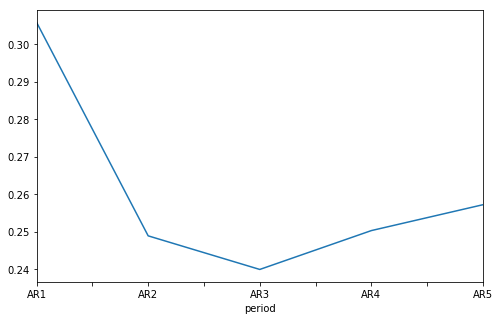

In [94]:
plt.rcParams["figure.figsize"] = [8,5]

df['std'].groupby(df['period']).mean().plot()

plt.show()

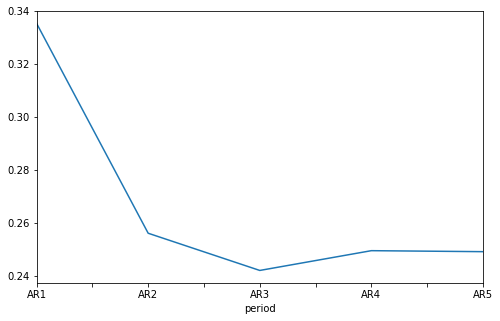

In [100]:
plt.rcParams["figure.figsize"] = [8,5]

df['weighted_std'].groupby(df['period']).mean().plot()

plt.show()

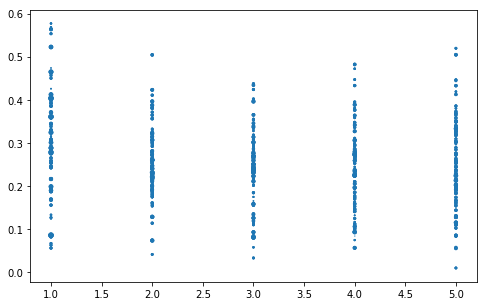

In [103]:
ar_dict= {}
for ar in AR.objects.all():
    ar_dict[ar.name] = ar.ar
x = [ar_dict[x] for x in df['period']]
plt.scatter(x,df['std'],s=df['year_share']*500)

plt.show()

In [88]:


df.head()

,WG,period,score,topic_id,topic_title,tpsum,share,tscore,std,year_share
1369,2,AR5,3.635646,9164,"{china, monsoon, chines}",11.197048,0.324697,520.983637,0.009456,0.006866
1368,1,AR5,3.715927,9164,"{china, monsoon, chines}",11.197048,0.331867,520.983637,0.009456,0.006866
1370,3,AR5,3.845475,9164,"{china, monsoon, chines}",11.197048,0.343436,520.983637,0.009456,0.006866
766,2,AR3,0.661433,9215,"{power, generat, nuclear}",1.801353,0.367187,475.060678,0.032712,0.006936
767,3,AR3,0.596098,9215,"{power, generat, nuclear}",1.801353,0.330917,475.060678,0.032712,0.006936


In [91]:
df

,WG,period,score,topic_id,topic_title,tpsum,share,tscore,std,year_share
1369,2,AR5,3.635646,9164,"{china, monsoon, chines}",11.197048,0.324697,520.983637,0.009456,0.006866
1368,1,AR5,3.715927,9164,"{china, monsoon, chines}",11.197048,0.331867,520.983637,0.009456,0.006866
1370,3,AR5,3.845475,9164,"{china, monsoon, chines}",11.197048,0.343436,520.983637,0.009456,0.006866
766,2,AR3,0.661433,9215,"{power, generat, nuclear}",1.801353,0.367187,475.060678,0.032712,0.006936
767,3,AR3,0.596098,9215,"{power, generat, nuclear}",1.801353,0.330917,475.060678,0.032712,0.006936
765,1,AR3,0.543822,9215,"{power, generat, nuclear}",1.801353,0.301897,475.060678,0.032712,0.006936
467,3,AR2,0.158952,9215,"{power, generat, nuclear}",0.499222,0.318400,475.060678,0.040990,0.006618
466,2,AR2,0.189553,9215,"{power, generat, nuclear}",0.499222,0.379696,475.060678,0.040990,0.006618
465,1,AR2,0.150717,9215,"{power, generat, nuclear}",0.499222,0.301904,475.060678,0.040990,0.006618
1446,1,AR5,3.733803,9172,"{fertil, treatment, nitrogen}",10.929935,0.341613,834.086807,0.054661,0.009979


## Entropy

In [ ]:
wg_dict = {'wg':1,'wg':2,'wg':3}
for wg in wg_dict:
    dts = DocTopic.objects.filter(
        run_id=run_id,
        doc__journal__id=j['journal__id'],
        score__gt=stat.dthreshold
    )
    H = 0
    ts = dts.values('topic').annotate(
        pzc = Sum('score')
    )
    for t in ts:
        H+=t['pzc']*np.log(t['pzc'])
    H = -1*H
    j['H'] = H
    print(round(H))

In [114]:
wg_dict = []

for p in periods:
    print(p.title)
    wgs = [
        {"WG":1, "score": 0},
        {"WG":2, "score": 0},
        {"WG":3, "score": 0}
    ]
    for wg in wgs:
        print(wg)
        dts = DocTopic.objects.filter(
            run_id=run_id,
            doc__ipccref__wg__wg=wg["WG"],
            doc__PY__in=p.ys,
            score__gt=stat.dthreshold
        )
        H = 0
        ts = dts.values('topic').annotate(
            pzc = Sum('score')
        )
        for t in ts:
            H+=t['pzc']*np.log(t['pzc'])
        H = -1*H
        print(H)
        wg['period'] = p.title
        wg['score'] = H
        wg_dict.append(wg)
        

AR1
{'score': 0, 'WG': 1}
-0.51544512872
{'score': 0, 'WG': 2}
2.1878691539
{'score': 0, 'WG': 3}
1.29609683289
AR2
{'score': 0, 'WG': 1}
-113.799496773
{'score': 0, 'WG': 2}
-36.0192002844
{'score': 0, 'WG': 3}
11.8535381802
AR3
{'score': 0, 'WG': 1}
-568.624555466
{'score': 0, 'WG': 2}
-459.169179349
{'score': 0, 'WG': 3}
-36.1793362234
AR4
{'score': 0, 'WG': 1}
-1020.90823864
{'score': 0, 'WG': 2}
-773.517210177
{'score': 0, 'WG': 3}
-71.2156320918
AR5
{'score': 0, 'WG': 1}
-759.994255756
{'score': 0, 'WG': 2}
-888.817739316
{'score': 0, 'WG': 3}
-167.713042583
AR6
{'score': 0, 'WG': 1}
0
{'score': 0, 'WG': 2}
5.04103974589
{'score': 0, 'WG': 3}
7.80348607125


In [123]:
en_df = pd.DataFrame.from_dict(wg_dict)

en_df.head()

en_df.tail()

,WG,period,score
13,2,AR5,-888.817739
14,3,AR5,-167.713043
15,1,AR6,0.000000
16,2,AR6,5.041040
17,3,AR6,7.803486


1
        WG        score
period                 
AR2      1  -113.799497
AR3      1  -568.624555
AR4      1 -1020.908239
AR5      1  -759.994256
2
        WG       score
period                
AR2      2  -36.019200
AR3      2 -459.169179
AR4      2 -773.517210
AR5      2 -888.817739
3
        WG       score
period                
AR2      3   11.853538
AR3      3  -36.179336
AR4      3  -71.215632
AR5      3 -167.713043


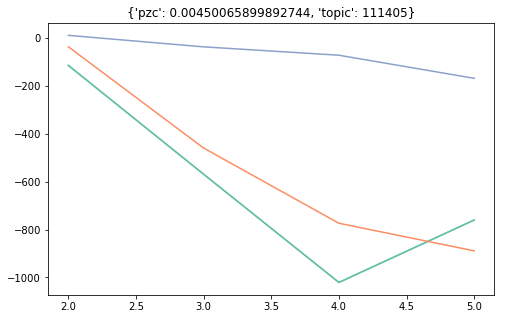

In [126]:
pdf = en_df[(en_df['period'] != "AR1") & (en_df['period'] != "AR6")].set_index('period')
for name, group in pdf.groupby('WG'):
    print(name)
    print(group)
    x = [x+2 for x in group.index.factorize()[0]]
    plt.plot(x,group['score'], color=colors[group['WG'][0]])
    plt.title(t)
    
plt.show()

In [132]:
wg_dict = []

for p in periods:
    print(p.title)
    wgs = [
        {"WG":1, "score": 0},
        {"WG":2, "score": 0},
        {"WG":3, "score": 0}
    ]
    for wg in wgs:
        print(wg)
        ts = DocTopic.objects.filter(
            run_id=run_id,
            doc__ipccref__wg__wg=wg["WG"],
            doc__PY__in=p.ys,
            score__gt=stat.dthreshold,
            topic__topicdtopic__dynamictopic__run_id=run_id
        ).values('topic__topicdtopic__dynamictopic').annotate(
            pzc = Sum(F('score') * F('topic__topicdtopic__score'))
        )
        
        
        #annotate(
        #    topic_combination = F('score') * F('topic__topicdtopic__score')
        #)
               
            
        #print(dts.values())
        
        H = 0
        #ts = dts.values('topic__topicdtopic__dynamictopic').annotate(
        #    pzc = Sum('topic_combination')
        #)
        for t in ts:
            H+=t['pzc']*np.log(t['pzc'])
        H = -1*H
        print(H)
        wg['period'] = p.title
        wg['score'] = H
        wg_dict.append(wg)
        

AR1
{'score': 0, 'WG': 1}
8.46084559728
{'score': 0, 'WG': 2}
5.08687414597
{'score': 0, 'WG': 3}
2.51362628677
AR2
{'score': 0, 'WG': 1}
-68.9682523615
{'score': 0, 'WG': 2}
-4.97441007418
{'score': 0, 'WG': 3}
20.5918786787
AR3
{'score': 0, 'WG': 1}
-883.528976074
{'score': 0, 'WG': 2}
-626.766027977
{'score': 0, 'WG': 3}
-50.2407875636
AR4
{'score': 0, 'WG': 1}
-2428.55121667
{'score': 0, 'WG': 2}
-1925.49124589
{'score': 0, 'WG': 3}
-240.654412881
AR5
{'score': 0, 'WG': 1}
-2443.07249623
{'score': 0, 'WG': 2}
-3200.43115999
{'score': 0, 'WG': 3}
-909.08882955
AR6
{'score': 0, 'WG': 1}
0
{'score': 0, 'WG': 2}
8.99681897472
{'score': 0, 'WG': 3}
11.9221738179


1
        WG        score
period                 
AR2      1   -68.968252
AR3      1  -883.528976
AR4      1 -2428.551217
AR5      1 -2443.072496
2
        WG        score
period                 
AR2      2    -4.974410
AR3      2  -626.766028
AR4      2 -1925.491246
AR5      2 -3200.431160
3
        WG       score
period                
AR2      3   20.591879
AR3      3  -50.240788
AR4      3 -240.654413
AR5      3 -909.088830


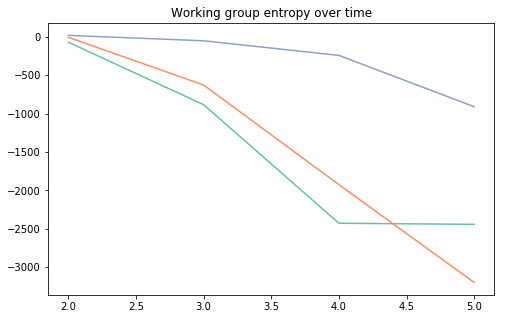

In [135]:
en_dt_df = pd.DataFrame.from_dict(wg_dict)

pdf = en_dt_df[(en_dt_df['period'] != "AR1") & (en_dt_df['period'] != "AR6")].set_index('period')
for name, group in pdf.groupby('WG'):
    print(name)
    print(group)
    x = [x+2 for x in group.index.factorize()[0]]
    plt.plot(x,group['score'], color=colors[group['WG'][0]])
    plt.title("Working group entropy over time")
    
plt.show()